In [2]:
from wandb.integration.keras import WandbMetricsLogger
from mlp_explainer import explainer, metrics
from scikeras.wrappers import KerasClassifier
from pgmpy.utils import get_example_model
from tensorflow import keras
import mlp_explainer
import numpy as np
import sklearn
import wandb
import copy

In [5]:
wandb.login()

True

In [6]:
ground_bn = get_example_model("alarm")

In [7]:
dataset = ground_bn.simulate(n_samples = 1000)

  0%|          | 0/37 [00:00<?, ?it/s]

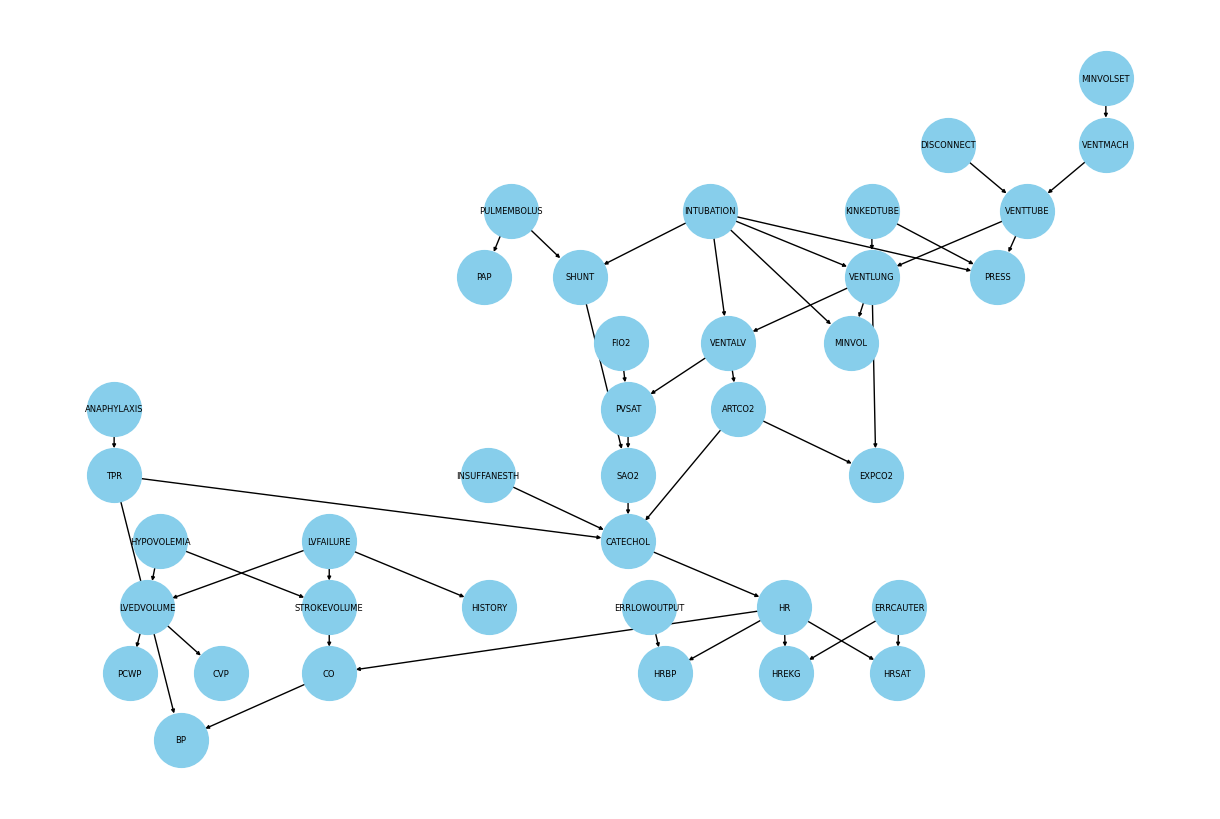

In [8]:
metrics.draw_network(ground_bn)

In [9]:
def build_model(input_shape, classes, n_layers = 5, n_nodes_l = 2, n_nodes_u = 10, optimizer = 'adam', learning_rate = 0.001):
    
    model = keras.Sequential()
    model.add(keras.Input(shape = (input_shape,)))
    for i in range(n_layers):
        model.add(keras.layers.Dense(np.random.choice([i for i in range(n_nodes_l, n_nodes_u)]), activation = np.random.choice(['relu', 'sigmoid'])))
    model.add(keras.layers.Dense(classes, activation = 'softmax'))

    if optimizer == 'sgd':
        optim = keras.optimizers.SGD(learning_rate = learning_rate)
    elif optimizer == 'adam':
        optim = keras.optimizers.Adam(learning_rate = learning_rate)
    
    model.compile(optimizer = optim, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [10]:
n_layers = 5
n_nodes_l = 5
n_nodes_u = 50
optimizer = 'adam'
learning_rate = 0.01
epochs = 25
batch_size = 64

In [11]:
target = "HR"

X = dataset.drop(target, axis = 1).to_numpy()
y = dataset[target].to_numpy()
    
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size = 0.1, random_state = 42, shuffle = True
)

input_shape = len(X_train[0])
n_classes = len(dataset[target].unique())

In [12]:
feature_encoder = sklearn.preprocessing.OrdinalEncoder()
feature_encoder.fit(X_train)
    
target_encoder = sklearn.preprocessing.LabelEncoder()
target_encoder.fit(y_train.squeeze())

LabelEncoder()

In [13]:
X_train_proc = feature_encoder.transform(X_train)
y_train_proc = target_encoder.transform(y_train)

In [14]:
wandb.init(entity = "computer-vision-wits", project = "MLP-E", name = "")
    
model = build_model(
    input_shape,
    n_classes,
    n_layers = n_layers, 
    n_nodes_l = n_nodes_l,
    n_nodes_u = n_nodes_u, 
    optimizer = optimizer, 
    learning_rate = learning_rate
)
    
config = wandb.config
config.n_layers = n_layers
config.n_nodes_l = n_nodes_l
config.n_nodes_u = n_nodes_u
config.optimizer = optimizer
config.epochs = epochs
config.batch_size = batch_size
config.learning_rate = learning_rate
config.target = target
    
model.fit(X_train_proc, y_train_proc, epochs = epochs, batch_size = batch_size, validation_split = 0.2, callbacks = [WandbMetricsLogger()])
model.summary()

wandb.finish()

Epoch 1/25


2025-10-01 19:48:13.122369: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8139 - loss: 0.5906 - val_accuracy: 0.7833 - val_loss: 0.6030
Epoch 2/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8139 - loss: 0.5415 - val_accuracy: 0.7833 - val_loss: 0.5411
Epoch 3/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8139 - loss: 0.4546 - val_accuracy: 0.7833 - val_loss: 0.3765
Epoch 4/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9014 - loss: 0.2802 - val_accuracy: 0.9278 - val_loss: 0.2932
Epoch 5/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9375 - loss: 0.2119 - val_accuracy: 0.9278 - val_loss: 0.2504
Epoch 6/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9597 - loss: 0.1670 - val_accuracy: 0.8889 - val_loss: 0.2936
Epoch 7/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9458 - loss: 0.1994 - val_accuracy: 0.9333 - val_loss: 0.2240
Epoch 8/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9542 - loss: 0.1635 - val_accuracy: 0.9389 - val_loss: 0.2056
Ep

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 44)             │         1,628 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 49)             │         2,205 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 36)             │           504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,932 (62.24 KB)

 Trainable params: 5,310 (20.74 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,622 (41.50 KB)

epoch/accuracy,▁▁▁▅▆▇▇▇▇▇▇▇█████████████
epoch/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▄▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▁▇▇▅▇▇▆▇▇█▇█████▇▇██▆██
epoch/val_loss,█▇▄▃▂▃▂▂▂▂▁▁▁▁▁▁▁▂▂▂▁▁▂▁▁
epoch/accuracy,0.975
epoch/epoch,24
epoch/learning_rate,0.01
epoch/loss,0.08673
epoch/val_accuracy,0.95556


In [15]:
X_test_proc = feature_encoder.transform(X_test)
y_test_proc = target_encoder.transform(y_test)

y_pred = model(X_test_proc)
y_pred = np.argmax(y_pred, axis = 1)
sklearn.metrics.accuracy_score(y_pred, y_test_proc)

0.97

In [164]:
import numpy as np
import pandas as pd
from pgmpy.base import DAG
from itertools import combinations
from pgmpy.estimators import HillClimbSearch, BIC, PC, CITests
from mlxtend.frequent_patterns import fpgrowth, association_rules

class Explainer:
    def __init__(self, model):
        
        self.model = model
        self.data = None
        self.bn = []
        self.dag = None

    def __data_generation(self, x: np.ndarray, X_train: np.ndarray, preproc, x_cols: list, y_col: str, n: int = 10, prob: float = 0.5):
        
        '''
        Args:
            x: a single local datapoint forming the base reference from which we sample perturbed instances.
            X_train: an array containing data used to train the model prior to preprocessing.
            preproc: the function used to preprocess input data prior to a forward pass to the model.
            x_cols: list of names of features.
            y_col: name of target.
            n: number of samples to draw from base reference local datapoint using perturbation scheme.
            prob: probability of replacing a randomly drawn datapoint from the training data with values from the base reference local datapoint.
        '''
        
        X = []
        Y = []
        
        proc_x = preproc.transform(x.reshape(1, -1))
        y = self.model.predict(proc_x, verbose = 0)
        y = y.reshape(len(y[0]),)
        
        for i in range(n):
            
            idx = np.random.randint(len(X_train))
            x_prime = X_train[idx]
            
            mask = np.random.rand(len(x_prime)) < prob
            x_prime = np.where(mask, x, x_prime)
            
            proc_x_prime = preproc.transform(x_prime.reshape(1, -1))
            y_prime = self.model.predict(proc_x_prime, verbose = 0)
            y_prime = y_prime.reshape(len(y_prime[0]),)
            
            y_prime = y_prime.argmax() != y.argmax()
            x_prime = x_prime != x
            
            X.append(x_prime.astype(int))
            Y.append(y_prime.astype(int))

        X = [X[i].astype(str) for i in range(len(X))]
        Y = [Y[i].astype(str) for i in range(len(Y))]
        
        self.data = pd.DataFrame(X, columns = x_cols)
        self.data[y_col] = Y

    def __structure_learning(self, data):

        pc = PC(data)
        model = pc.estimate(return_type = "dag", significance_level = 0.05)
        self.bn.append(model)

    def __associations(self):
        
        stable_list = [set(edge) for edge in list(self.bn[0].edges)]
        unstable_list = [set(edge) for edge in list(self.bn[1].edges)]
        
        intersection_edges = [unstable_list[i] for i in range(len(unstable_list)) if unstable_list[i] in stable_list]
        intersection_edges = [tuple(edge) for edge in intersection_edges]

        self.dag = DAG(intersection_edges)

    def explain(self, x, X_train, preproc, x_cols, y_col, n, prob) -> None:
        
        x = np.asarray(x)
        
        self.__data_generation(x, X_train, preproc, x_cols, y_col, n, prob)
        
        classes = np.unique(self.data['HR'].values)
        
        for class_ in classes:
            data = self.data.loc[self.data['HR'] == class_]
            data = data.drop('HR', axis = 1)
            self.__structure_learning(data)
        self.__associations()

In [165]:
explainer = Explainer(model)
x = X[np.random.randint(len(X))]

x_cols = dataset.drop(target, axis = 1).columns
y_col = target

explainer.explain(x, X_train, feature_encoder, x_cols, y_col, 1000, 0.25)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'CATECHOL': 'C', 'KINKEDTUBE': 'C', 'HISTORY': 'C', 'PAP': 'C', 'ERRLOWOUTPUT': 'C', 'MINVOLSET': 'C', 'ANAPHYLAXIS': 'C', 'PRESS': 'C', 'CVP': 'C', 'CO': 'C', 'HRSAT': 'C', 'PVSAT': 'C', 'VENTALV': 'C', 'VENTMACH': 'C', 'FIO2': 'C', 'STROKEVOLUME': 'C', 'EXPCO2': 'C', 'PCWP': 'C', 'TPR': 'C', 'BP': 'C', 'HRBP': 'C', 'LVEDVOLUME': 'C', 'VENTLUNG': 'C', 'LVFAILURE': 'C', 'ARTCO2': 'C', 'INTUBATION': 'C', 'MINVOL': 'C', 'SAO2': 'C', 'SHUNT': 'C', 'PULMEMBOLUS': 'C', 'INSUFFANESTH': 'C', 'DISCONNECT': 'C', 'ERRCAUTER': 'C', 'HREKG': 'C', 'VENTTUBE': 'C', 'HYPOVOLEMIA': 'C'}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'CATECHOL': 'C', 'KINKEDTUBE': 'C', 'HISTORY': 'C', 'PAP': 'C', 'ERRLOWOUTPUT': 'C', 'MINVOLSET': 'C', 'ANAPHYLAXIS': 'C', 'PRESS': 'C', 'CVP': 'C', 'CO': 'C', 'HRSAT': 'C', 'PVSAT': 'C', 'VENTALV': 'C', 'VENTMACH': 'C', 'FIO2': 'C', 'STROKEVOLUME': 'C', 'EXPCO2': 'C', 'PCWP': 'C', 'TPR': 'C', 'BP': 'C', 'HRBP': 'C', 'LVEDVOLUME': 'C', 'VENTLUNG': 'C', 'LVFAILURE': 'C', 'ARTCO2': 'C', 'INTUBATION': 'C', 'MINVOL': 'C', 'SAO2': 'C', 'SHUNT': 'C', 'PULMEMBOLUS': 'C', 'INSUFFANESTH': 'C', 'DISCONNECT': 'C', 'ERRCAUTER': 'C', 'HREKG': 'C', 'VENTTUBE': 'C', 'HYPOVOLEMIA': 'C'}


  0%|          | 0/5 [00:00<?, ?it/s]

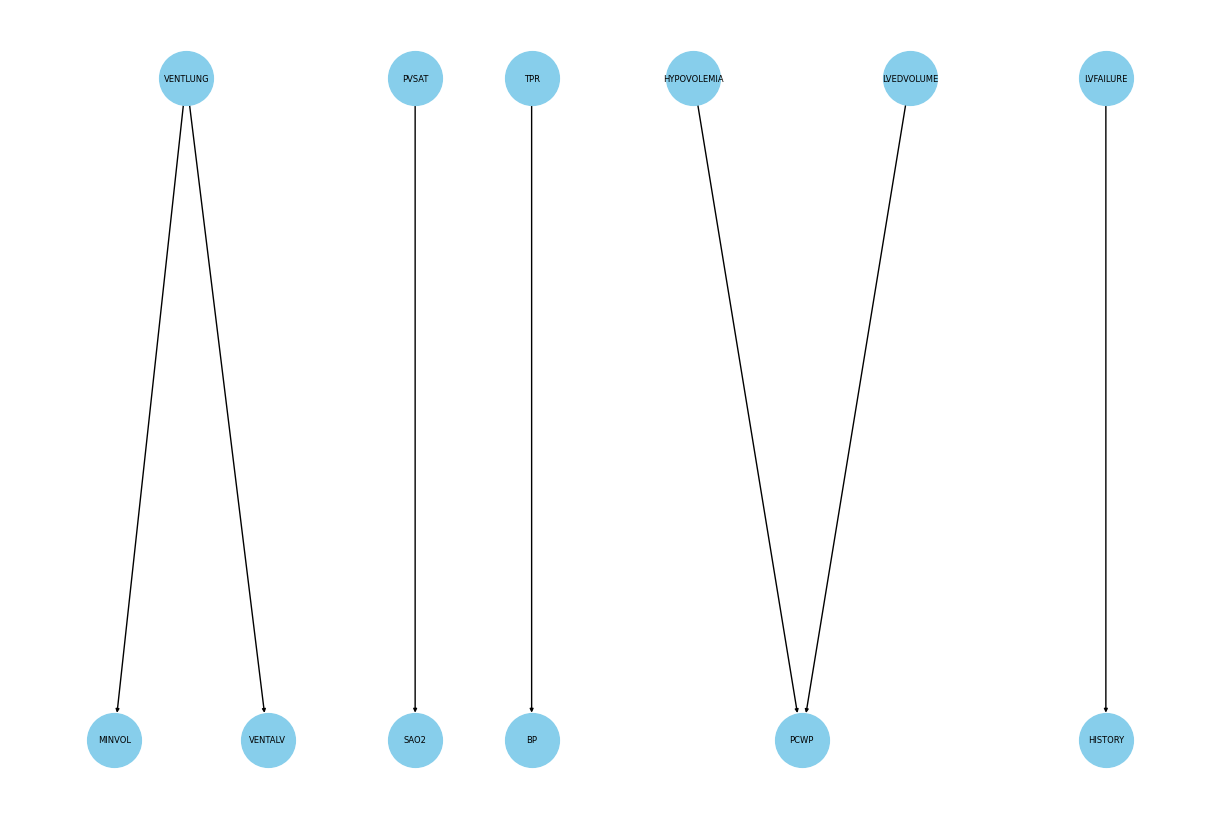

In [166]:
metrics.draw_network(explainer.dag)

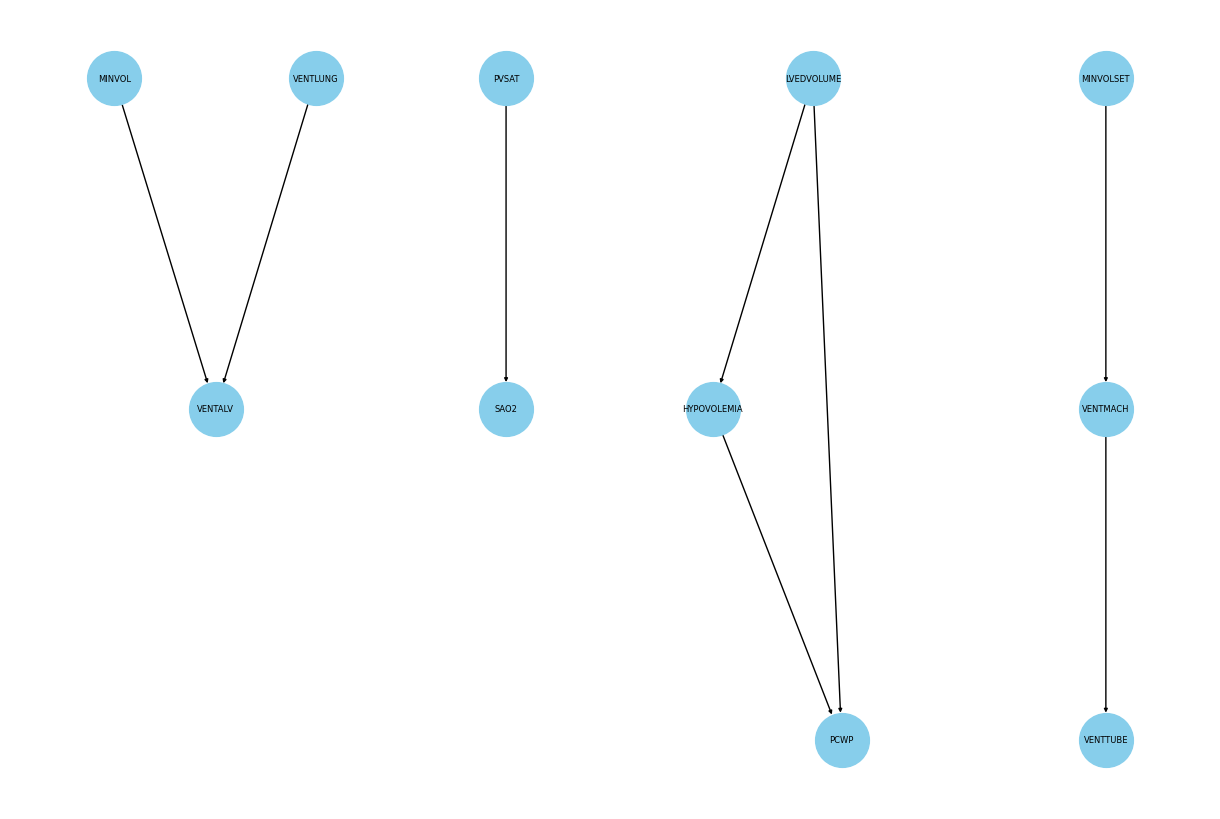

In [163]:
metrics.draw_network(explainer.dag)